[I 2025-04-17 22:35:21,561] A new study created in memory with name: no-name-e2e30758-9b2f-4828-8f3d-14806b401a6d
[I 2025-04-17 22:35:30,590] Trial 0 finished with value: 0.8482339955849889 and parameters: {'lr': 0.2555811698025176, 'depth': 4, 'l2': 9.662990654062664}. Best is trial 0 with value: 0.8482339955849889.
[I 2025-04-17 22:35:50,594] Trial 1 finished with value: 0.8431357090297488 and parameters: {'lr': 0.2490116802858895, 'depth': 8, 'l2': 7.344543661249703}. Best is trial 0 with value: 0.8482339955849889.
[I 2025-04-17 22:36:09,989] Trial 2 finished with value: 0.8473667612740461 and parameters: {'lr': 0.09146611758439878, 'depth': 8, 'l2': 1.9795757835358136}. Best is trial 0 with value: 0.8482339955849889.
[I 2025-04-17 22:36:48,960] Trial 3 finished with value: 0.8381951014401345 and parameters: {'lr': 0.28338859099362695, 'depth': 10, 'l2': 8.176182547793843}. Best is trial 0 with value: 0.8482339955849889.
[I 2025-04-17 22:37:14,875] Trial 4 finished with value: 0.847

Best Params: {'lr': 0.08733549360757242, 'depth': 8, 'l2': 6.421387961727578}
=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92     32055
         1.0       0.00      0.00      0.00       695
         2.0       0.54      0.23      0.32      5302

    accuracy                           0.85     38052
   macro avg       0.47      0.40      0.41     38052
weighted avg       0.81      0.85      0.82     38052



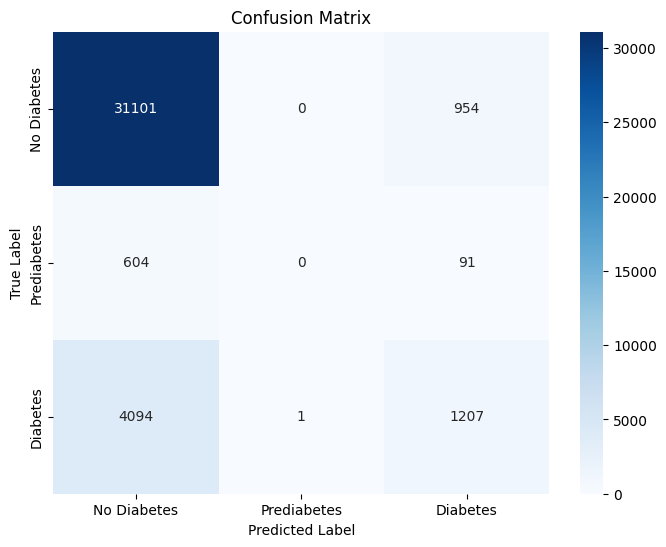

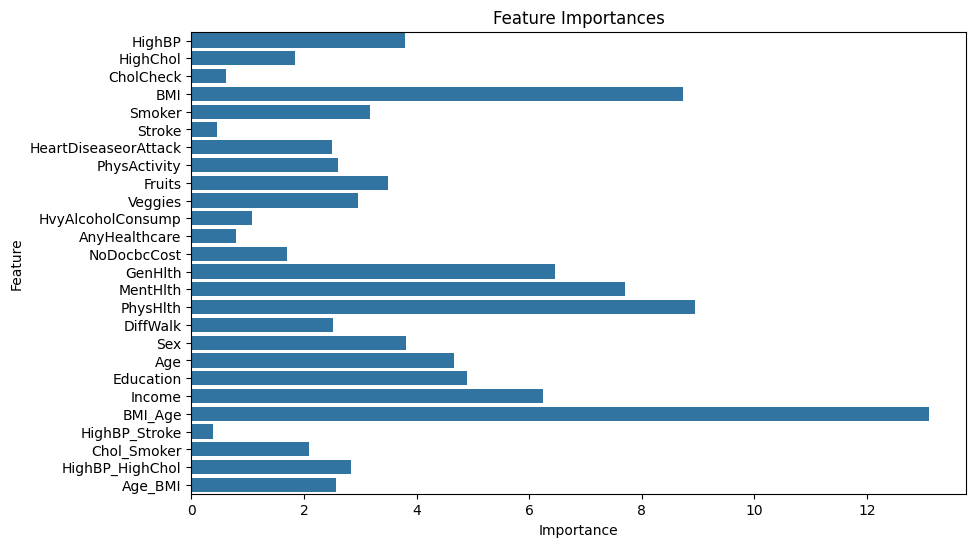

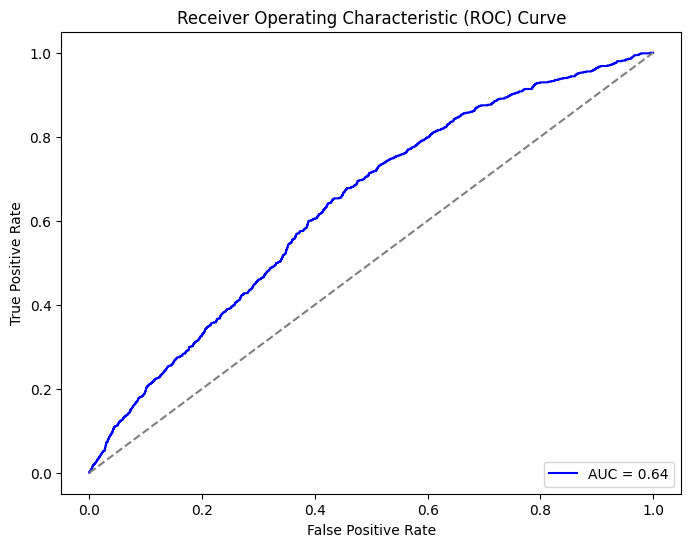

=== Confusion Matrix ===
[[31101     0   954]
 [  604     0    91]
 [ 4094     1  1207]]


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier, Pool
import optuna

# Tải dữ liệu
df = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")

# Xử lý label
y = df["Diabetes_012"]
X = df.drop("Diabetes_012", axis=1)

# Chuyển đổi sang kiểu dữ liệu boolean trước khi sử dụng toán tử & (với các cột 'HighBP' và 'Stroke')
df['HighBP'] = df['HighBP'].astype(bool)
df['Stroke'] = df['Stroke'].astype(bool)

# Tăng feature interaction phức tạp
df['BMI_Age'] = df['BMI'] * df['Age']
df['HighBP_Stroke'] = df['HighBP'] & df['Stroke']  # Sử dụng toán tử & sau khi chuyển thành boolean
df['Chol_Smoker'] = df['HighChol'] * df['Smoker']
df['HighBP_HighChol'] = df['HighBP'] * df['HighChol']
df['Age_BMI'] = df['Age'] * df['BMI']


# Cập nhật X sau khi thêm feature interaction
X = df.drop("Diabetes_012", axis=1)

# Tách numeric và categorical
categorical_features = X.select_dtypes(include=['int64', 'object']).columns.tolist()

# Train-test split (85/15)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.15, random_state=42)

# SMOTE để cân bằng lớp
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Tạo Pool cho CatBoost
train_pool = Pool(X_train_bal, y_train_bal, cat_features=categorical_features)
test_pool = Pool(X_test, cat_features=categorical_features)

# Định nghĩa hàm tối ưu hóa với Optuna
def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("lr", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2", 1, 10),
        "task_type": "GPU",
        "loss_function": "MultiClass",
        "eval_metric": "Accuracy",
        "random_seed": 42,
        "verbose": 0
    }

    model = CatBoostClassifier(**params)
    model.fit(train_pool)
    preds = model.predict(test_pool)
    acc = (preds.flatten() == y_test).mean()
    return acc

# Tối ưu hyperparameters với Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# In ra thông số tối ưu
print("Best Params:", study.best_params)

# Huấn luyện mô hình với hyperparameters tốt nhất
best_params = study.best_params
best_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=best_params['lr'],
    depth=best_params['depth'],
    l2_leaf_reg=best_params['l2'],
    task_type="GPU",
    loss_function="MultiClass",
    eval_metric="Accuracy",
    random_seed=42,
    verbose=0
)

# Đào tạo mô hình với dữ liệu huấn luyện
best_model.fit(train_pool)

# Dự đoán kết quả trên tập kiểm tra
y_pred = best_model.predict(test_pool)

# Đánh giá mô hình
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Vẽ Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature Importances
feature_importances = best_model.get_feature_importance(Pool(X_train, label=y_train, cat_features=categorical_features))

# Vẽ Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=X.columns)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Plotting ROC Curve
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(test_pool)[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

# Vẽ ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Optional: Nếu bạn muốn xem kết quả trên từng class
print("=== Confusion Matrix ===")
print(conf_matrix)


In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, f1_score, roc_auc_score
import lightgbm as lgb
import optuna
from imblearn.over_sampling import SMOTE

# Load dataset
data = pd.read_csv('diabetic_data.csv')

# Replace '?' with NaN
data = data.replace('?', np.nan)

# Convert 'weight' to numeric
data['weight'] = pd.to_numeric(data['weight'], errors='coerce')

# Convert medication columns to binary (Yes=1, No=0)
medication_columns = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
                      'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
                      'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
                      'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
                      'glipizide-metformin', 'glimepiride-pioglitazone',
                      'metformin-rosiglitazone', 'metformin-pioglitazone']

for col in medication_columns:
    data[col] = data[col].apply(lambda x: 1 if x == 'Yes' else 0)

# Map 'max_glu_serum'
glu_mapping = {'None': 0, 'Norm': 1, '>200': 2, '>300': 3}
data['max_glu_serum'] = data['max_glu_serum'].map(glu_mapping).fillna(0)

# Convert 'age' like '[70-80)' to integer (e.g., 70)
data['age'] = data['age'].apply(lambda x: int(x.strip('[]()').split('-')[0]) if isinstance(x, str) else 0)

# Encode categorical variables
categorical_columns = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
                       'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'A1Cresult', 'change',
                       'diabetesMed', 'readmitted']

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

# Split features and target
X = data.drop(columns=['readmitted'])
y = data['readmitted']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate numeric and non-numeric columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
non_numeric_cols = X_train.select_dtypes(exclude=[np.number]).columns

# Impute only numeric columns
imputer = SimpleImputer(strategy='mean')
X_train_numeric = pd.DataFrame(imputer.fit_transform(X_train[numeric_cols]), columns=numeric_cols)

# Keep non-numeric columns as-is (if any exist)
if not non_numeric_cols.empty:
    X_train_cleaned = pd.concat([X_train_numeric, X_train[non_numeric_cols].reset_index(drop=True)], axis=1)
else:
    X_train_cleaned = X_train_numeric

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X_train_cleaned, y_train)

# Define Optuna objective function
def objective(trial):
    param = {
        'objective': 'multiclass',
        'num_class': len(np.unique(y)),
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'class_weight': 'balanced'
    }
    
    model = lgb.LGBMClassifier(**param)
    model.fit(X_res, y_res)
    return model.score(X_test, y_test)

# Optimize with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Train final model
best_params = study.best_params
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_res, y_res)

# Evaluate
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)

# Print classification metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))

# Only print ROC-AUC for binary
if len(np.unique(y)) == 2:
    print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba[:, 1]))

# Cross-validation
cv_scores = cross_val_score(final_model, X_res, y_res, cv=5, scoring='accuracy')
print(f"CV Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()}")


c:\Users\ndat4\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['weight']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


ValueError: Shape of passed values is (81412, 48), indices imply (81412, 49)

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")

print("Path to dataset files:", path)


ModuleNotFoundError: No module named 'kagglehub'